## 3. *Taxi Trip Duration*: Predicción de duración de viaje

In [200]:
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

>a) Cargue los datos de entrenamiento como dataframes de pandas. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distinto. Grafique adecuadamente el valor a predecir con algún gráfico que resuma su comportamiento, e.g. un histograma, boxplot u otro.

In [110]:
import pandas as pd
df = pd.read_csv("train.csv")
df.info()
df.head()
output = df['trip_duration'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Las variables del dataset son

id - identificador del viaje

vendor_id - identificador del proveedor del servicio

pickup_datetime - fecha y hora en la que se prendio el taximetro

dropoff_datetime - fecha y hora en la que se apago el taximetro

passenger_count - numero de pasajeros

pickup_longitude - longitud en la que se prendio el taximetro

pickup_latitude - latitud en la que se prendio el taximetro

dropoff_longitude - longitud en la que se prendio el taximetro

dropoff_latitude - latitud en la que se prendio el taximetro

store_and_fwd_flag - flag de si el viaje se guardo en memoria si al terminar el viaje no se podia conectar al servidor

trip_duration - duracion del viaje, variable dependiente



Hay 1458644 datos en total, con 11 atributos

duracion maxima: 23.997777777777777 horas


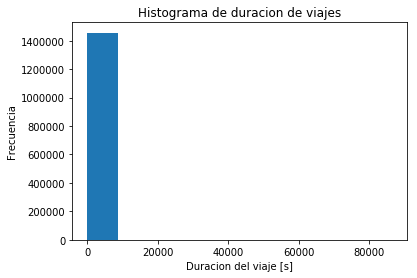

In [221]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

n, bins, patches = ax.hist(output,bins = 10)


ax.set_xlabel('Duracion del viaje [s]')
ax.set_ylabel('Frecuencia')
ax.set_title("Histograma de duracion de viajes")


print("duracion maxima:",max(output)/3600,"horas")

Claramente hay varios outliers, primero se eliminan estos.

>b) Como puede observar en los análisis preliminares exiten algunos outliers en los datos los cuales pensamos eliminar para que no entorpezca el aprendizaje, además que son muy pocos.

In [112]:
import pandas as pd
df = df[(df['trip_duration']<=200000)]
df.info()
df.head()
output = df['trip_duration'].values



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458640 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458640 non-null object
vendor_id             1458640 non-null int64
pickup_datetime       1458640 non-null object
dropoff_datetime      1458640 non-null object
passenger_count       1458640 non-null int64
pickup_longitude      1458640 non-null float64
pickup_latitude       1458640 non-null float64
dropoff_longitude     1458640 non-null float64
dropoff_latitude      1458640 non-null float64
store_and_fwd_flag    1458640 non-null object
trip_duration         1458640 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 133.5+ MB


Se reducen a 1458640 datos.

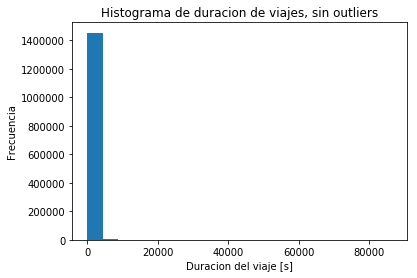

duracion maxima: 23.997777777777777 horas


In [113]:
fig, ax = plt.subplots()

n, bins, patches = ax.hist(output,bins = 20)


ax.set_xlabel('Duracion del viaje [s]')
ax.set_ylabel('Frecuencia')
ax.set_title("Histograma de duracion de viajes, sin outliers")


plt.show()
print("duracion maxima:",max(output)/3600,"horas")

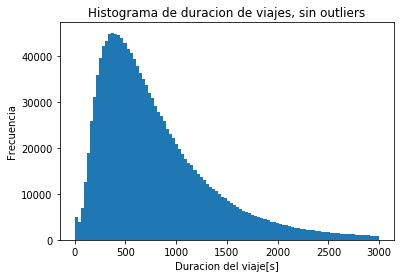

duracion maxima: 23.997777777777777 horas
duracion media: 0.2646709032995728 horas


In [114]:
fig, ax = plt.subplots()

df2 = df[(df['trip_duration']<=3000)]
output2 = df2['trip_duration'].values


n, bins, patches = ax.hist(output2,bins = 100)


ax.set_xlabel('Duracion del viaje[s]')
ax.set_ylabel('Frecuencia')
ax.set_title("Histograma de duracion de viajes, sin outliers")


plt.show()
print("duracion maxima:",max(output)/3600,"horas")
print("duracion media:",np.mean(output)/3600,"horas")

Se aprecia una asimetria positiva (skewness), y que el tiempo promedio de viaje es de 15 minutos.

>c) La primera operación que realizaremos a los datos como pre-procesamiento será la de extraer/generar características de manera manual de algunos atributos que resulta necesario hcaer, como desde la fecha (string) puede ser extraída la hora del día, creando una nueva columna denominada hour y de tipo int discreto, o bien, para la localización del viaje punto a punto se pueden extraer distintas medidas de distancia. Comente sobre el pre-procesamiento realizado. 

In [115]:
from geopy.distance import great_circle
import numpy as np
"""extraer caract geograficas"""

##Distancia en la geodesica
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all

##angulo central de dos puntos
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360

#feriados
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')


def preprocesar(df):
    df.fillna(0,inplace=True)
    
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    
    
    
    
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    
    
    
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    
    
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,cday,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,1,-73.982155,40.767937,-73.964630,40.765602,455,17,0,3,0.017680,1.498523,99.970196,1,0
1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,6,6,0.020456,1.805510,242.846232,2,0
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,11,1,1,0.059934,6.385108,200.319835,0,0
3,1,-74.010040,40.719971,-74.012268,40.706718,429,19,2,4,0.013438,1.485501,187.262300,1,0
4,1,-73.973053,40.793209,-73.972923,40.782520,435,13,5,3,0.010690,1.188590,179.473585,1,0


Se hace un preprocesamiento para extraer las caracteristicas que se utilizaran y eliminar las redundantes. Las operaciones realizadas son:

De la fecha  de cuando  parte y termina el viaje, se extrae:
el dia y mes, dia de la semana, si es feriado, la estacion del año y la duracion del viaje.

De las coordenadas de cuando parte y termina el viaje, se extrae:
la distancia entre grados (esta no tiene sentido ya que son distancias de latitudes y longitudes), la distancia geodesica y el angulo central

Este preprocesamiento se hace principalmente para mejorar el entrenamiento al pasarle al modelo la informacion relevante del problema.

>d) Cree las estructuras de los datos a utilizar, además de crear el conjunto de pruebas para validar los modelos ¿Cuáles son las dimensiones de cada conjunto? Normalice los datos, elija algún scaler y comente sobre su decisión.

In [116]:
y = df['trip_duration'].values
df.drop("trip_duration",axis=1,inplace=True)

In [134]:

X = df.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=42)
from sklearn.preprocessing import RobustScaler,StandardScaler

X_test=X_test[:100000]
y_test=y_test[:100000]


scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("train", len(X_train_scaled))
print("test", len(X_test_scaled))

train 14586
test 100000


La diferencia entre el StandardScaler y RobustScaler, es que el standar deja los datos con media o y varianza 1, mientras que el robust deja los datos con mediana 0 y rango intercuartil 1 (diferencia entre el percentil 25 y 75), esto tiene la ventaja de reducir el efecto de los outliers, ya que se eliminaron los outliers se utilizara el scaler standar. Hay 14586 datos de entrenamiento y 10000 datos de validacion, estos se reducieron por temas de computo.

>e) En base a la definición del problema de ésta sección y a lo experimentado en la sección 1, escoga un modelo de aprendizaje para experimentar en la predicción de la duración del viaje, comente sobre su decisión. Entrene el modelo escogido, usando parámetros por defecto, sobre la representación escalada generada anteriormente y mida el error de la competencia RMSLE sobre ambos conjuntos, comente.

Se probara utilizara una SVM y una red neuronal.

In [205]:
from sklearn.svm import SVR 

modelsvr= SVR()
modelsvr.set_params(kernel='rbf')
modelsvr.fit(X_train_scaled,y_train)
print ("ERROR RMSLE de training: ", rmsle(modelsvr.predict(X_train_scaled),y_train))
print ("ERROR RMSLE de test: ", rmsle(modelsvr.predict(X_test_scaled),y_test))

ERROR RMSLE de training:  0.6631509520354643
ERROR RMSLE de test:  0.6748340661367066


Como es de esperar, el error es menor en el entrenamiento que en el testeo. 

In [231]:
from keras.models import Sequential
from keras.layers.core import Dense 
from keras import backend as K
import tensorflow as tf

def custom_rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)

    y_pred_log = K.log(y_pred + 1.)
    y_true_log = K.log(y_true + 1.)
    
    return K.sqrt(K.mean(K.square(y_pred_log - y_true_log), axis = -1))

modelred = Sequential()
modelred.add(Dense(10, input_dim=X_train.shape[1], activation="relu"))
modelred.add(Dense(1, activation="relu"))
modelred.compile(optimizer = "SGD", loss = custom_rmsle)

modelred.fit(X_train_scaled, y_train, epochs=100, batch_size=100)

print ("ERROR RMSLE de training: ", rmsle(modelred.predict(X_train_scaled),y_train))
print ("ERROR RMSLE de test: ", rmsle(modelred.predict(X_test_scaled),y_test))


Epoch 1/100
14586/14586 [==============================] - 1s 56us/step - loss: 6.0287
Epoch 2/100
14586/14586 [==============================] - 0s 8us/step - loss: 5.2910
Epoch 3/100
14586/14586 [==============================] - 0s 8us/step - loss: 4.8769
Epoch 4/100
14586/14586 [==============================] - 0s 8us/step - loss: 4.5867
Epoch 5/100
14586/14586 [==============================] - 0s 8us/step - loss: 4.3510
Epoch 6/100
14586/14586 [==============================] - 0s 7us/step - loss: 4.1504
Epoch 7/100
14586/14586 [==============================] - 0s 8us/step - loss: 3.9760
Epoch 8/100
14586/14586 [==============================] - 0s 8us/step - loss: 3.8222
Epoch 9/100
14586/14586 [==============================] - 0s 7us/step - loss: 3.6847
Epoch 10/100
14586/14586 [==============================] - 0s 8us/step - loss: 3.5608
Epoch 11/100
14586/14586 [==============================] - 0s 7us/step - loss: 3.4482
Epoch 12/100
14586/14586 [=========================

14586/14586 [==============================] - 0s 8us/step - loss: 1.1130
Epoch 96/100
14586/14586 [==============================] - 0s 7us/step - loss: 1.1048
Epoch 97/100
14586/14586 [==============================] - 0s 7us/step - loss: 1.0968
Epoch 98/100
14586/14586 [==============================] - 0s 8us/step - loss: 1.0889
Epoch 99/100
14586/14586 [==============================] - 0s 8us/step - loss: 1.0811
Epoch 100/100
14586/14586 [==============================] - 0s 7us/step - loss: 1.0734
ERROR RMSLE de training:  [1.2599216]
ERROR RMSLE de test:  [1.26680226]


Para la red se obtienen resultados levemente mejores que la SVM, es el modelo que se ocupara en adelante.

>f) Grafique las predicciones generadas por su modelo vs el valor real ¿Cuál es el comportamiento esperado? ¿Su resultado se asemeja a éste? ¿Por qué?

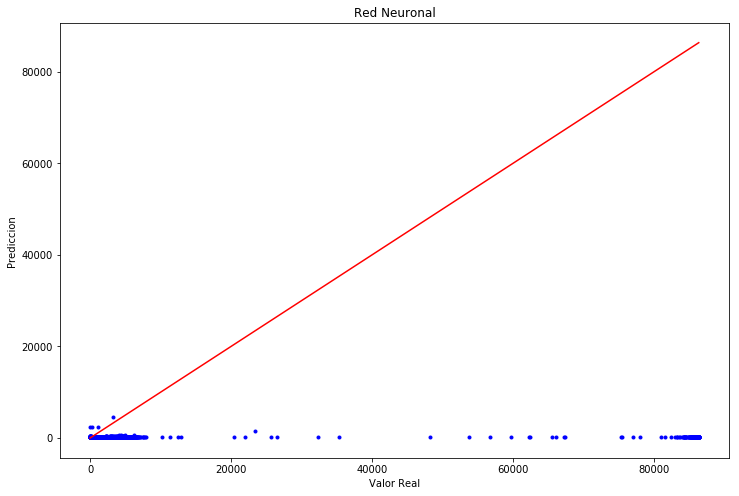

In [232]:
def graficar_predicciones(real,predecido,title):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.title(title)
    plt.show()
graficar_predicciones(y_test,modelred.predict(X_test_scaled),'Red Neuronal')

Se espera que los puntos esten cercanos a la recta x=y, sin embargo esta claro que el modelo subestima los valores reales, se conjetura que haciendo un refinamiento correcto de los hiper parametros se obtendran mejores resultados.

>g) Mejore el desempeño del modelo de aprendizaje definido en e) haciendo modificaciones a los hiper-parámetros del modelo. Por ejemplo, tener ojo con el sobre-ajuste del modelo. Naturalmente, está absolutamente prohibido tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento. 

Se cambia la topologia de la red a una de dos capas con 1000 neuronas cada una. Para evitar el overfitting se utiliza la tecnica del "dropout", que fuerza a una proporcion de las neuronas en una capa a anularse, esto tiene un efecto regularizante sobre la red.

In [238]:
from keras.layers.core import Dropout

modelred = Sequential()
modelred.add(Dense(1000, input_dim=X_train.shape[1], activation="relu"))
modelred.add(Dropout(0.4))
modelred.add(Dense(1000, input_dim=X_train.shape[1], activation="relu"))
modelred.add(Dense(1, activation="relu"))
modelred.compile(optimizer = "SGD", loss = custom_rmsle)

modelred.fit(X_train_scaled, y_train, epochs=100, batch_size=100)

print ("ERROR RMSLE de training: ", rmsle(modelred.predict(X_train_scaled),y_train))
print ("ERROR RMSLE de test: ", rmsle(modelred.predict(X_test_scaled),y_test))


Epoch 1/100
14586/14586 [==============================] - 3s 176us/step - loss: 5.2361
Epoch 2/100
14586/14586 [==============================] - 2s 119us/step - loss: 4.2196
Epoch 3/100
14586/14586 [==============================] - 2s 116us/step - loss: 3.6344
Epoch 4/100
14586/14586 [==============================] - 2s 116us/step - loss: 3.2083
Epoch 5/100
14586/14586 [==============================] - 2s 122us/step - loss: 2.8722
Epoch 6/100
14586/14586 [==============================] - 2s 126us/step - loss: 2.5937
Epoch 7/100
14586/14586 [==============================] - 2s 125us/step - loss: 2.3576
Epoch 8/100
14586/14586 [==============================] - 2s 114us/step - loss: 2.1534
Epoch 9/100
14586/14586 [==============================] - 2s 115us/step - loss: 1.9735
Epoch 10/100
14586/14586 [==============================] - 2s 121us/step - loss: 1.8150
Epoch 11/100
14586/14586 [==============================] - 2s 115us/step - loss: 1.6740
Epoch 12/100
14586/14586 [====

14586/14586 [==============================] - 2s 127us/step - loss: 0.4317
Epoch 94/100
14586/14586 [==============================] - 2s 135us/step - loss: 0.4303
Epoch 95/100
14586/14586 [==============================] - 2s 132us/step - loss: 0.4290
Epoch 96/100
14586/14586 [==============================] - 2s 127us/step - loss: 0.4282
Epoch 97/100
14586/14586 [==============================] - 2s 128us/step - loss: 0.4278
Epoch 98/100
14586/14586 [==============================] - 2s 125us/step - loss: 0.4263
Epoch 99/100
14586/14586 [==============================] - 2s 121us/step - loss: 0.4258
Epoch 100/100
14586/14586 [==============================] - 2s 122us/step - loss: 0.4251
ERROR RMSLE de training:  [0.5955489]
ERROR RMSLE de test:  [0.60877846]


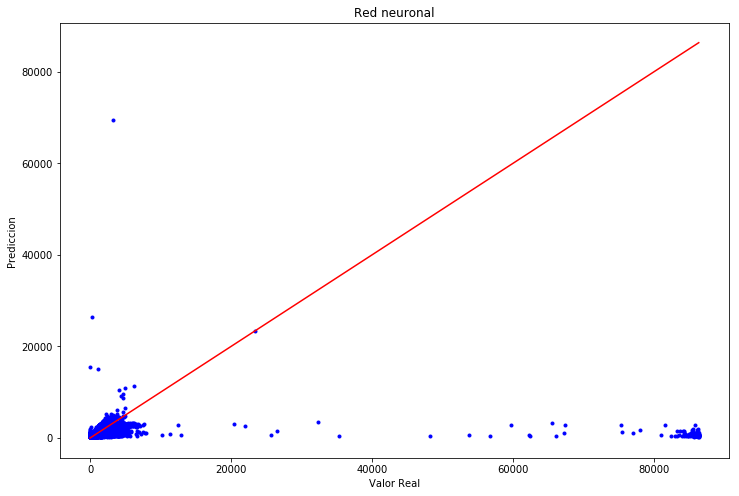

In [239]:
def graficar_predicciones(real,predecido,title):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.title(title)
    plt.show()
graficar_predicciones(y_test,modelred.predict(X_test_scaled),'Red neuronal')

Hay una mejora en el el error de los datos, sin embargo, la curva de comparacion prediccion y real esta lejos de ser satisfactoria.